<a href="https://colab.research.google.com/github/Goecol/dnn_unet/blob/main/Test_on_Unet_Project_DNN_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch torchvision torchcam matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00


Load Unet and Initialize Grad-CAM

In [3]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu


# The custom UNet module is defined as a subclass of nn.Module.
# The __init__ method (which is the constructor of the defined UNet module) initializes the architecture of the U-Net by defining the layers for both the encoder and decoder parts of the network.
# The argument num_of_classes specifies the number of classes for the segmentation task.
# When this UNet module is called, the argument (num_of_classes) must be passed
class UNet(nn.Module):
    def __init__(self, num_of_classes):
        super().__init__()

        # ------------------ ENCODER ---------------------------------------------------
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.en11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.en12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.en21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.en22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.en31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.en32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.en41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.en42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.en51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.en52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # ------------------ DECODER ---------------------------------------------------
        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image.
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, num_of_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        xen11 = relu(self.en11(x)) # x output for the encoder11
        xen12 = relu(self.en12(xen11))
        xp1 = self.pool1(xen12) # x output for the pooling layer

        xen21 = relu(self.en21(xp1))
        xen22 = relu(self.en22(xen21))
        xp2 = self.pool2(xen22)

        xen31 = relu(self.en31(xp2))
        xen32 = relu(self.en32(xen31))
        xp3 = self.pool3(xen32)

        xen41 = relu(self.en41(xp3))
        xen42 = relu(self.en42(xen41))
        xp4 = self.pool4(xen42)

        xen51 = relu(self.en51(xp4))
        xen52 = relu(self.en52(xen51))

        # Decoder
        xu1 = self.upconv1(xen52)
        xu11 = torch.cat([xu1, xen42], dim=1)
        xdec11 = relu(self.dec11(xu11))
        xdec12 = relu(self.dec12(xdec11))

        xu2 = self.upconv2(xdec12)
        xu22 = torch.cat([xu2, xen32], dim=1)
        xdec21 = relu(self.dec21(xu22))
        xdec22 = relu(self.dec22(xdec21))

        xu3 = self.upconv3(xdec22)
        xu33 = torch.cat([xu3, xen22], dim=1)
        xdec31 = relu(self.dec31(xu33))
        xdec32 = relu(self.dec32(xdec31))

        xu4 = self.upconv4(xdec32)
        xu44 = torch.cat([xu4, xen12], dim=1)
        xdec41 = relu(self.dec41(xu44))
        xdec42 = relu(self.dec42(xdec41))

        # Output layer
        out = self.outconv(xdec42)

        return out



#import test

#test.run(UNet)

In [5]:
import torch
#import torchvision.models as models
from torchcam.methods import GradCAM

# Load the UNet model
model = UNet(num_of_classes=2)
model.eval()  # Set to evaluation mode

# Select the last convolutional layer for Grad-CAM
target_layer = model.outconv  # Last convolutional layer of AlexNet

# Initialize Grad-CAM
cam_extractor = GradCAM(model, target_layer)


Prepare an Input Image Let's use an image of a cat as an example

In [6]:
from google.colab import files
uploaded = files.upload()

Saving input_image.png to input_image.png


Uploaded file: input_image.png


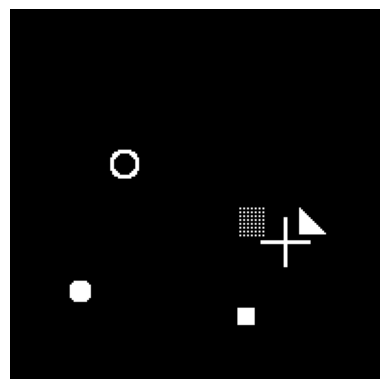

In [7]:
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)


from PIL import Image
import matplotlib.pyplot as plt

# Open the image using PIL
image = Image.open(filename)

# Display the image with matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


In [8]:
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from PIL import Image

# Preprocess the image
preprocess = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension


Forward Pass and Generate Heatmap

In [11]:
# Forward pass through the model
output = model(input_tensor)

# Instead of argmax on the entire output, get argmax for each pixel in the output
# assuming the class dimension is 1
predicted_class = output.argmax(dim=1)

# For GradCAM, you might need to select a specific pixel or average
# the predicted class across the spatial dimensions.
# Here's an example of averaging:
# Convert predicted_class to a floating-point type before calculating the mean
average_predicted_class = predicted_class.type(torch.float32).mean().int().item()

# Extract Grad-CAM heatmap for the predicted class
heatmap = cam_extractor(average_predicted_class, output)

Visualize the Heatmap Overlay the Grad-CAM heatmap on the original image:

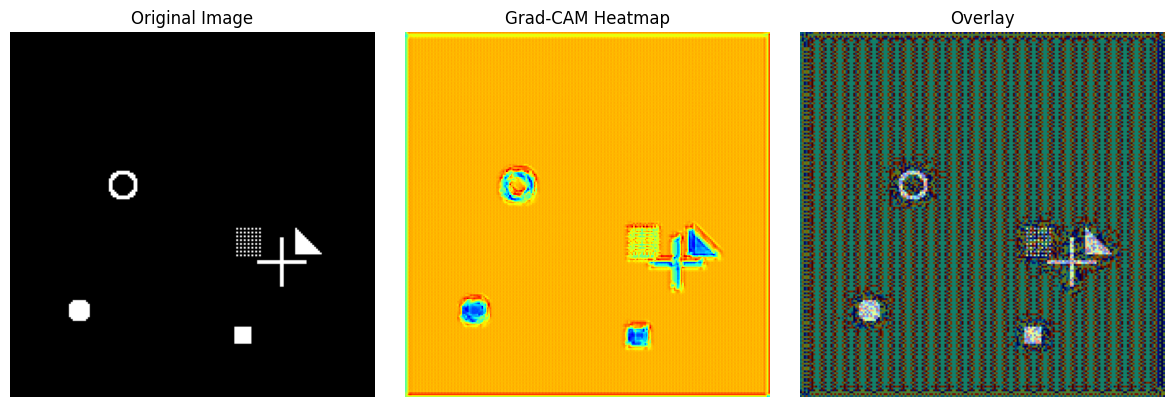

In [12]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image # Import to_pil_image

# Convert the heatmap tensor to a PIL Image
heatmap_pil = to_pil_image(heatmap[0])

# Overlay the heatmap on the image
result = overlay_mask(image, heatmap_pil, alpha=0.5) # Pass heatmap_pil instead of heatmap[0]

# Display the original image, heatmap, and overlay
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Heatmap
plt.subplot(1, 3, 2)
# Squeeze the heatmap to remove the extra dimension before displaying
plt.imshow(heatmap[0].squeeze(), cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()